In [82]:
import os
import json
import pickle
from time import time
import shap

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV

def mae(true, pred):
    return np.mean(np.abs(true - pred))

In [83]:
data = pd.read_csv(os.path.join('data', 'steps_030_newcases.csv'))

In [84]:
X, y = data.drop(columns=['target']), data['target']

In [85]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2)

In [86]:
model = XGBRegressor(verbosity=1) 

In [87]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=1)

In [88]:
preds = model.predict(X_test)
error = mae(y_test, preds)
print(f'Test mae is {error:.5}')
      
preds = model.predict(X_train)
error = mae(y_train, preds)
print(f'Train mae is {error:.5}')

Test mae is 50.763
Train mae is 27.751


In [89]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train, check_additivity=False)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
# shap.force_plot(explainer.expected_value, shap_values[200,:], X_train.iloc[200,:], matplotlib=True)

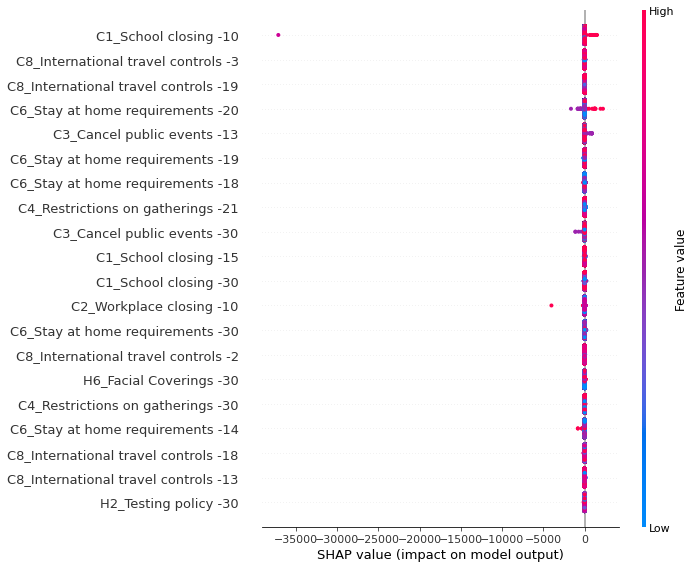

In [90]:
removed_columns = [f'MA {i}' for i in range(-30, 0, 1)]

shap.summary_plot(shap_values[:, 30:], X_train.drop(columns=removed_columns))

In [91]:
importances = {}

keys = ['MA',
        'C1_School closing',
        'C2_Workplace closing',
        'C3_Cancel public events',
        'C4_Restrictions on gatherings',
        'C5_Close public transport',
        'C6_Stay at home requirements',
        'C7_Restrictions on internal movement',
        'C8_International travel controls',
        'H1_Public information campaigns',
        'H2_Testing policy',
        'H3_Contact tracing',
        'H6_Facial Coverings']

for i, key in enumerate(keys):
    feat_importance = shap_values[:, i*30: i*30 + 30].sum()
    
    importances[key] = feat_importance

In [92]:
importances

{'MA': 631459.0,
 'C1_School closing': -628072.8,
 'C2_Workplace closing': 18012.684,
 'C3_Cancel public events': -31566.834,
 'C4_Restrictions on gatherings': 70995.14,
 'C5_Close public transport': -2104.0867,
 'C6_Stay at home requirements': -16101.17,
 'C7_Restrictions on internal movement': -22827.262,
 'C8_International travel controls': 11873.953,
 'H1_Public information campaigns': -593.49524,
 'H2_Testing policy': -34890.797,
 'H3_Contact tracing': 655.09186,
 'H6_Facial Coverings': 3158.5603}

In [93]:
X_train.columns

Index(['MA -30', 'MA -29', 'MA -28', 'MA -27', 'MA -26', 'MA -25', 'MA -24',
       'MA -23', 'MA -22', 'MA -21',
       ...
       'H6_Facial Coverings -10', 'H6_Facial Coverings -9',
       'H6_Facial Coverings -8', 'H6_Facial Coverings -7',
       'H6_Facial Coverings -6', 'H6_Facial Coverings -5',
       'H6_Facial Coverings -4', 'H6_Facial Coverings -3',
       'H6_Facial Coverings -2', 'H6_Facial Coverings -1'],
      dtype='object', length=390)